In [3]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [4]:
data = pd.read_csv('OV2.csv', on_bad_lines='skip', sep=';')
data = pd.DataFrame(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15207 entries, 0 to 15206
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              15207 non-null  object 
 1   Streams           15207 non-null  int64  
 2   Viewers           15207 non-null  int64  
 3   Dominant_streams  15207 non-null  int64  
 4   Dominant_ratio    15207 non-null  float64
 5   Tags              15207 non-null  object 
 6   Name              15207 non-null  object 
 7   Title             15207 non-null  object 
 8   Beginning         15207 non-null  object 
 9   Unnamed: 9        94 non-null     object 
 10  Unnamed: 10       46 non-null     object 
dtypes: float64(1), int64(3), object(7)
memory usage: 1.3+ MB


In [82]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S', errors='coerce')
data = data.dropna()
data['Hour'] = data['Date'].dt.hour
data['Minute'] = data['Date'].dt.hour
data['Weekday'] = data['Date'].dt.weekday
data['Moving_streams'] = data['Streams'].rolling(10, min_periods=1).mean()

data.info()

,Date,Streams,Viewers,Dominant_streams,Dominant_ratio,Tags,Name,Title,Beginning,Unnamed: 9,Unnamed: 10,Hour,Minute,Weekday,Moving_streams
0,2023-03-11 12:06:00,1,5,1,1.0,"[['Polski', 'DropyWłączone', 'Depresja', 'Hand...",['dariocosta'],"['1W - 1L | Gold 2 dps | Z rana Overek, a wiec...",['2023-03-11T10:27:52Z'],NaN,NaN,12,12,5,1.0
1,2023-03-11 12:08:00,1,5,1,1.0,"[['Polski', 'DropyWłączone', 'Depresja', 'Hand...",['dariocosta'],"['1W - 1L | Gold 2 dps | Z rana Overek, a wiec...",['2023-03-11T10:27:52Z'],NaN,NaN,12,12,5,1.0
2,2023-03-11 12:10:00,1,6,1,1.0,"[['Polski', 'DropyWłączone', 'Depresja', 'Hand...",['dariocosta'],"['1W - 1L | Gold 2 dps | Z rana Overek, a wiec...",['2023-03-11T10:27:52Z'],NaN,NaN,12,12,5,1.0
3,2023-03-11 12:12:00,1,6,1,1.0,"[['Polski', 'DropyWłączone', 'Depresja', 'Hand...",['dariocosta'],"['1W - 1L | Gold 2 dps | Z rana Overek, a wiec...",['2023-03-11T10:27:52Z'],NaN,NaN,12,12,5,1.0
4,2023-03-11 12:14:00,1,6,1,1.0,"[['Polski', 'DropyWłączone', 'Depresja', 'Hand...",['dariocosta'],"['1W - 1L | Gold 2 dps | Z rana Overek, a wiec...",['2023-03-11T10:27:52Z'],NaN,NaN,12,12,5,1.0


In [83]:
X = data[['Hour','Minute','Weekday']]
y = data[['Moving_streams']]

#y = data[['Moving_streams']]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=False)
y_test = y_test.reset_index()

In [85]:
xgb_model = xgb.XGBRegressor(n_estimators = 100, max_depth=3, learning_rate=0.05)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

#For measuring accuracy 
y_pred = y_pred.astype(int)
y_test['Moving_streams'] = y_test['Moving_streams'].astype(int)



wynik = 0
wynik_list =[]
#For bigger games
# for i in range(len(y_test)):
#     temp = max(y_pred[i],y_test['Moving_streams'][i]) / min(y_pred[i],y_test['Moving_streams'][i])
#     temp = ((temp * 100) - 100) * 10
#     temp = 100 - temp
#     if temp > 0:
#         wynik += temp/100
#         wynik_list.append(temp)
#     else:
#         wynik += 0
#         wynik_list.append(0)

for i in range(len(y_test)):
    if y_test['Moving_streams'][i] == y_pred[i]:
        wynik += 1
        wynik_list.append(100)
    elif y_pred[i] == y_test['Moving_streams'][i] + 1 or  y_pred[i] == y_test['Moving_streams'][i] - 1:
        wynik += 0.5
        wynik_list.append(50)
    else:
        wynik += 0 
        wynik_list.append(0)

# For bigger games
# df = pd.DataFrame(y_pred)
# df['should'] = y_test['Moving_streams']
# df['result'] = wynik_list
# df.columns = ['is','should','result']
# display(df)

print(wynik/len(y_test))

df = pd.DataFrame(y_pred)
df['should'] = y_test['Moving_streams']
df['result'] = wynik_list
df.columns = ['is','should','result']
display(df)

# calculate MSE
mse = mean_squared_error(y_test['Moving_streams'], y_pred)
print("Mean squared error:", mse)


0.46583442838370565


,is,should,result
0,4,6,0
1,4,6,0
2,4,6,0
3,4,6,0
4,4,6,0
...,...,...,...
756,5,4,50
757,5,4,50
758,5,4,50
759,5,4,50


In [ ]:
from sklearn.model_selection import GridSearchCV

# zdefiniowanie siatki parametrów do przeszukania
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.01, 0.1],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 0.1, 1],
}

# inicjalizacja GridSearchCV z zadanymi parametrami
grid_search = GridSearchCV(
    xgb_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# przeszukanie siatki parametrów
grid_search.fit(X, y)

# wydrukowanie najlepszych wyników
print(f"Najlepsze wyniki: {grid_search.best_params_}")
print(f"Najlepszy wynik: {grid_search.best_score_}")

In [86]:

new_data = pd.DataFrame({'Hour': [17], 'Minute': [0], 'Weekday': [0]})
prediction = xgb_model.predict(new_data)

print('Score: ', prediction)

Score:  [7.037115]


In [27]:
xgb_model.feature_importances_

array([0.91818583, 0.        , 0.08181416], dtype=float32)

In [70]:
from sklearn.ensemble import IsolationForest

X = data[['Hour','Minute','Weekday','Streams']]

isof = IsolationForest(n_estimators=1000, contamination=0.1)
isof.fit(X)

new_data = pd.DataFrame({'Hour': [17], 'Minute': [12], 'Weekday': [0], 'Streams': [11]})
display(new_data)
prediction = isof.predict(new_data)

print('Wynik: ', prediction)


c:\Users\tymot\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Hour,Minute,Weekday,Streams
0,17,12,0,11


Wynik:  [-1]


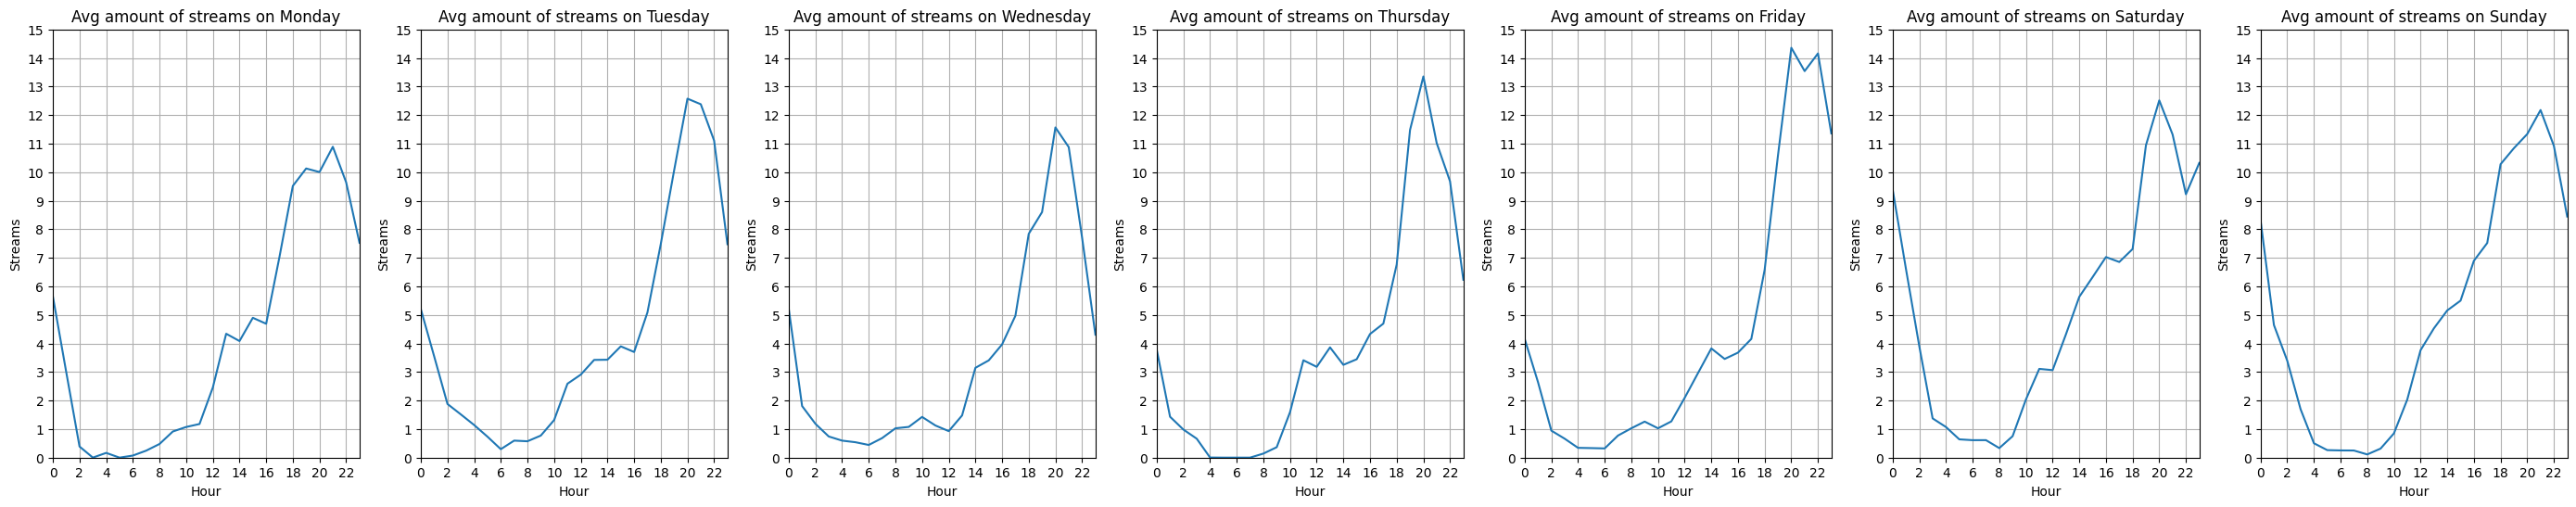

In [176]:
df_grouped = data.groupby(['Weekday', 'Hour'])['Moving_streams'].mean().reset_index()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

weeks_name = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(35, 6))

for i in weeks_name.keys():
    group = df_grouped[df_grouped['Weekday'] == i]
    sns.lineplot(data=group, x='Hour', y='Moving_streams', ax=axs[i])
    axs[i].set_title(f"Avg amount of streams on {weeks_name[i]}")
    axs[i].set_xlabel("Hour")
    axs[i].set_ylabel("Streams")
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[i].set_xlim(left=0, right=23)
    axs[i].set_ylim(bottom=0, top=15)
    axs[i].grid()
    
plt.show()

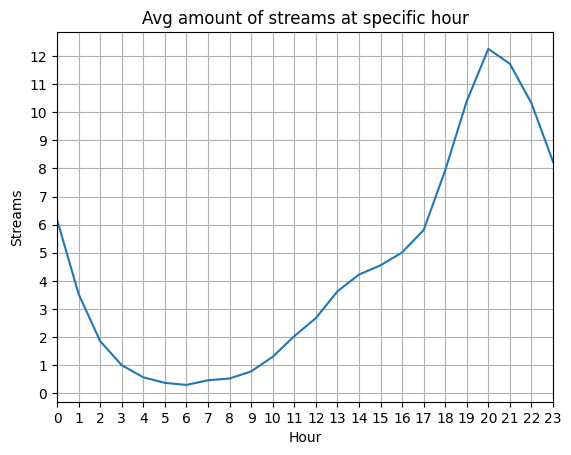

In [175]:
df_grouped = data.groupby(['Hour'])['Moving_streams'].mean().reset_index()

plt.plot(df_grouped['Hour'], df_grouped['Moving_streams'])
plt.title("Avg amount of streams at specific hour")
plt.xlabel("Hour")
plt.ylabel("Streams")
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().set_xlim(left=0, right=23)
plt.grid()